# Imports

In [1]:
import logging
from pathlib import Path
import geopandas as gpd
import numpy as np
import sys
import subprocess

import matplotlib.pyplot as plt
from imageio import imread

from multiview_mapping_toolkit.segmentation import (
    write_chips,
    assemble_tiled_predictions,
)
from multiview_mapping_toolkit.utils.prediction_metrics import plot_geodata
from multiview_mapping_toolkit.utils.geospatial import get_overlap_raster
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf

sys.path.append("../..")
from constants import (
    get_inference_raster_filename,
    get_inference_chips_folder,
    get_work_dir,
    get_prediction_folder,
    get_IDs_to_labels,
    get_aggregated_raster_pred_file,
    get_figure_export_confusion_matrix_file,
    get_numpy_export_confusion_matrix_file,
    CHIP_SIZE,
    INFERENCE_STRIDE,
    INFERENCE_SCRIPT,
    BATCH_SIZE,
    INFERENCE_IMGS_EXT,
    MMSEG_PYTHON,
    MMSEG_UTILS_PYTHON,
    LABELS_FILENAME,
    LABELS_COLUMN,
    VIS_PREDS_SCRIPT,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define constants 

In [2]:
INFERENCE_SITE = "none"
training_sites = ["none", "none"]

In [4]:
logging.basicConfig(level="INFO")

/tmp/ipykernel_8413/4118039719.py:4: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf.query(f"fire=='{INFERENCE_SITE}'").plot(LABEL_COLUMN, legend=True, vmin=0, vmax=9)


<Axes: >

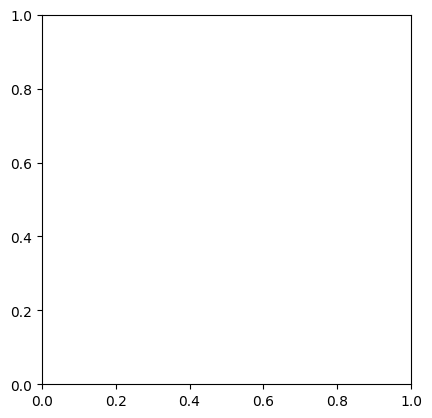

In [5]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)

gdf.query(f"fire=='{INFERENCE_SITE}'").plot(LABELS_COLUMN, legend=True, vmin=0, vmax=9)

# Create training chips

In [6]:
INFERENCE_RASTER_FILENAME = get_inference_raster_filename(inference_site=INFERENCE_SITE)
INFERENCE_CHIPS_FOLDER = get_inference_chips_folder(inference_site=INFERENCE_SITE)

write_chips(
    raster_file=INFERENCE_RASTER_FILENAME,
    output_folder=INFERENCE_CHIPS_FOLDER,
    chip_size=CHIP_SIZE,
    chip_stride=INFERENCE_STRIDE,
    output_suffix=INFERENCE_IMGS_EXT,
    ROI_file=LABELS_FILENAME,
)

INFO:rasterio._env:GDAL signalled an error: err_no=4, msg='/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/none/02_photogrammetry/exports/orthos/none.tif: No such file or directory'


RasterioIOError: /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/none/02_photogrammetry/exports/orthos/none.tif: No such file or directory

In [ ]:
files = list(INFERENCE_CHIPS_FOLDER.glob("*" + INFERENCE_IMGS_EXT))
np.random.shuffle(files)
for file in files[:3]:
    plt.imshow(imread(file))
    plt.show()

In [ ]:
WORK_DIR = get_work_dir(training_sites=training_sites, is_ortho=True)
PREDICTIONS_FOLDER = get_prediction_folder(
    prediction_site=INFERENCE_SITE, training_sites=training_sites
)

config_file = list(Path(WORK_DIR).glob("*py"))[0]
checkpoint_file = Path(WORK_DIR, "iter_10000.pth")

subprocess.run(
    f"{MMSEG_PYTHON} {INFERENCE_SCRIPT} {config_file} {checkpoint_file} {INFERENCE_CHIPS_FOLDER} {PREDICTIONS_FOLDER} --batch-size {BATCH_SIZE}",
    shell=True,
)

In [ ]:
# Add _vis to the folder name. Can't just add _vis to the str representation because it might have a trailing slash
pred_vis_dir = Path(
    Path(PREDICTIONS_FOLDER).parent, Path(PREDICTIONS_FOLDER).parts[-1] + "_vis"
)
STRIDE = 1

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {VIS_PREDS_SCRIPT} --image-dir {INFERENCE_CHIPS_FOLDER} "
    + f"--seg-dir {PREDICTIONS_FOLDER} --output-dir {pred_vis_dir} --stride {STRIDE}",
    shell=True,
)

In [ ]:
files = list(pred_vis_dir.glob("*"))
np.random.shuffle(files)
for file in files[:3]:
    print(file)
    plt.imshow(imread(file))
    plt.show()

In [ ]:
pred_files = list(PREDICTIONS_FOLDER.glob("*"))
num_classes = len(get_IDs_to_labels())
AGGREGATED_RASTER_PRED_FILE = get_aggregated_raster_pred_file(
    training_sites=training_sites, inference_site=INFERENCE_SITE
)

assemble_tiled_predictions(
    raster_input_file=INFERENCE_RASTER_FILENAME,
    pred_files=pred_files,
    num_classes=num_classes,
    class_savefile=AGGREGATED_RASTER_PRED_FILE,
)

In [ ]:
_, ax = plt.subplots(1, 1)
plot_geodata(AGGREGATED_RASTER_PRED_FILE, ax=ax)

# Assign labels to regions

In [ ]:
class_fractions, IDs_in_original = get_overlap_raster(
    unlabeled_df=LABELS_FILENAME,
    classes_raster=AGGREGATED_RASTER_PRED_FILE,
    num_classes=num_classes,
)

In [ ]:
pred_IDs = np.argmax(class_fractions, axis=1)
IDS_TO_LABELS = get_IDs_to_labels()

pred_class = [IDS_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABELS_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

In [ ]:
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = get_numpy_export_confusion_matrix_file(
    inference_site=INFERENCE_SITE, is_ortho=True
)
FIGURE_EXPORT_CONFUSION_MATRIX_FILE = get_figure_export_confusion_matrix_file(
    inference_site=INFERENCE_SITE, is_ortho=True
)

gt_list = site_gdf[LABELS_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

cf, classess, accuracy = compute_and_show_cf(
    pred_labels=pred_list, gt_labels=gt_list, labels=list(IDS_TO_LABELS.values())
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)
print(f"Accuracy: {accuracy}")
# Export the image of the confusion matrix
compute_and_show_cf(
    pred_labels=pred_list,
    gt_labels=gt_list,
    labels=list(IDS_TO_LABELS.values()),
    savefile=FIGURE_EXPORT_CONFUSION_MATRIX_FILE,
)